In [1]:

import numpy as np
import matplotlib.pyplot as plt

class KalmanFilter(object):
    def __init__(self, dt, u_x,u_y, std_acc, x_std_meas, y_std_meas):
        """
        :param dt: sampling time (time for 1 cycle)
        :param u_x: acceleration in x-direction
        :param u_y: acceleration in y-direction
        :param std_acc: process noise magnitude
        :param x_std_meas: standard deviation of the measurement in x-direction
        :param y_std_meas: standard deviation of the measurement in y-direction
        """

        # Define sampling time
        self.dt = dt

        # Define the  control input variables
        self.u = np.matrix([[u_x],[u_y]])

        # Intial State
        self.x = np.matrix([[0], [0], [0], [0]])

        # Define the State Transition Matrix A
        self.A = np.matrix([[1, 0, self.dt, 0],
                            [0, 1, 0, self.dt],
                            [0, 0, 1, 0],
                            [0, 0, 0, 1]])

        # Define the Control Input Matrix B
        self.B = np.matrix([[(self.dt**2)/2, 0],
                            [0,(self.dt**2)/2],
                            [self.dt,0],
                            [0,self.dt]])

        # Define Measurement Mapping Matrix
        self.H = np.matrix([[1, 0, 0, 0],
                            [0, 1, 0, 0]])

        #Initial Process Noise Covariance
        self.Q = np.matrix([[(self.dt**4)/4, 0, (self.dt**3)/2, 0],
                            [0, (self.dt**4)/4, 0, (self.dt**3)/2],
                            [(self.dt**3)/2, 0, self.dt**2, 0],
                            [0, (self.dt**3)/2, 0, self.dt**2]]) * std_acc**2

        #Initial Measurement Noise Covariance
        self.R = np.matrix([[x_std_meas**2,0],
                           [0, y_std_meas**2]])

        #Initial Covariance Matrix
        self.P = np.eye(self.A.shape[1])

    def predict(self):

        # Update time state
        #x_k =Ax_(k-1) + Bu_(k-1)     
        self.x = np.dot(self.A, self.x) + np.dot(self.B, self.u)

        # Calculate error covariance
        # P= A*P*A' + Q             
        self.P = np.dot(np.dot(self.A, self.P), self.A.T) + self.Q
        return self.x[0:2]

    def update(self, z):

        # S = H*P*H'+R
        S = np.dot(self.H, np.dot(self.P, self.H.T)) + self.R

        # Calculate the Kalman Gain
        # K = P * H'* inv(H*P*H'+R)
        K = np.dot(np.dot(self.P, self.H.T), np.linalg.inv(S))  

        self.x = np.round(self.x + np.dot(K, (z - np.dot(self.H, self.x))))   

        I = np.eye(self.H.shape[1])

        # Update error covariance matrix
        self.P = (I - (K * self.H)) * self.P   
        return self.x[0:2]

In [2]:

def detect(frame, debugMode):
    # Convert frame from BGR to GRAY
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    if debugMode:
        cv2.imshow('image', gray)
        cv2.waitKey(1)  # Add a small delay to display the image

    # Edge detection using Canny function
    img_edges = cv2.Canny(gray, 50, 190, 3)

    if debugMode:
        cv2.imshow('image', img_edges)
        cv2.waitKey(1)

    # Convert to black and white image
    ret, img_thresh = cv2.threshold(img_edges, 254, 255, cv2.THRESH_BINARY)

    if debugMode:
        cv2.imshow('image', img_thresh)
        cv2.waitKey(1)

    # Find contours
    contours, _ = cv2.findContours(img_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Set the accepted minimum & maximum radius of a detected object
    min_radius_thresh = 3
    max_radius_thresh = 30

    centers = []
    for c in contours:
        # ref: https://docs.opencv.org/trunk/dd/d49/tutorial_py_contour_features.html
        (x, y), radius = cv2.minEnclosingCircle(c)
        radius = int(radius)

        # Take only the valid circle(s)
        if min_radius_thresh < radius < max_radius_thresh:
            centers.append(np.array([[x], [y]]))

    return centers


In [3]:
import cv2


In [4]:


def main():
    # Create opencv video capture object
    VideoCap = cv2.VideoCapture('randomball.avi')

    # Variable used to control the speed of reading the video
    ControlSpeedVar = 100  # Lowest: 1 - Highest:100

    HiSpeed = 100

    # Create KalmanFilter object KF
    KF = KalmanFilter(0.1, 1, 1, 1, 0.1, 0.1)

    debugMode = 1

    while True:
        # Read frame
        ret, frame = VideoCap.read()

        # Detect object
        centers = detect(frame, debugMode)

        # If centroids are detected then track them
        if len(centers) > 0:
            # Draw the detected circle
            cv2.circle(frame, (int(centers[0][0]), int(centers[0][1])), 10, (0, 191, 255), 2)

            # Predict
            (x, y) = KF.predict()
            # Draw a rectangle as the predicted object position
            cv2.rectangle(frame, (int(x) - 15, int(y) - 15), (int(x) + 15, int(y) + 15), (255, 0, 0), 2)

            # Update
            (x1, y1) = KF.update(centers[0])

            # Draw a rectangle as the estimated object position
            cv2.rectangle(frame, (int(x1) - 15, int(y1) - 15), (int(x1) + 15, int(y1) + 15), (0, 0, 255), 2)

            cv2.putText(frame, "Estimated Position", (int(x1) + 15, int(y1) + 10), 0, 0.5, (0, 0, 255), 2)
            cv2.putText(frame, "Predicted Position", (int(x) + 15, int(y)), 0, 0.5, (255, 0, 0), 2)
            cv2.putText(frame, "Measured Position", (int(centers[0][0]) + 15, int(centers[0][1]) - 15), 0, 0.5,
                        (0, 191, 255), 2)

        cv2.imshow('image', frame)

        if cv2.waitKey(500) & 0xFF == ord('q'):
            VideoCap.release()
            cv2.destroyAllWindows()
            break

        cv2.waitKey(HiSpeed - ControlSpeedVar + 1)

if __name__ == "__main__":
    # execute main
    main()


QObject::moveToThread: Current thread (0x3d029f90) is not the object's thread (0x3d785990).
Cannot move to target thread (0x3d029f90)

QObject::moveToThread: Current thread (0x3d029f90) is not the object's thread (0x3d785990).
Cannot move to target thread (0x3d029f90)

QObject::moveToThread: Current thread (0x3d029f90) is not the object's thread (0x3d785990).
Cannot move to target thread (0x3d029f90)

QObject::moveToThread: Current thread (0x3d029f90) is not the object's thread (0x3d785990).
Cannot move to target thread (0x3d029f90)

QObject::moveToThread: Current thread (0x3d029f90) is not the object's thread (0x3d785990).
Cannot move to target thread (0x3d029f90)

QObject::moveToThread: Current thread (0x3d029f90) is not the object's thread (0x3d785990).
Cannot move to target thread (0x3d029f90)

QObject::moveToThread: Current thread (0x3d029f90) is not the object's thread (0x3d785990).
Cannot move to target thread (0x3d029f90)

QObject::moveToThread: Current thread (0x3d029f90) is n

In [5]:
import matplotlib.pyplot as plt


QObject::moveToThread: Current thread (0x3d029f90) is not the object's thread (0x3d785990).
Cannot move to target thread (0x3d029f90)

QObject::moveToThread: Current thread (0x3d029f90) is not the object's thread (0x3d785990).
Cannot move to target thread (0x3d029f90)

QObject::moveToThread: Current thread (0x3d029f90) is not the object's thread (0x3d785990).
Cannot move to target thread (0x3d029f90)

QObject::moveToThread: Current thread (0x3d029f90) is not the object's thread (0x3d785990).
Cannot move to target thread (0x3d029f90)

QObject::moveToThread: Current thread (0x3d029f90) is not the object's thread (0x3d785990).
Cannot move to target thread (0x3d029f90)

QObject::moveToThread: Current thread (0x3d029f90) is not the object's thread (0x3d785990).
Cannot move to target thread (0x3d029f90)

QObject::moveToThread: Current thread (0x3d029f90) is not the object's thread (0x3d785990).
Cannot move to target thread (0x3d029f90)

QObject::moveToThread: Current thread (0x3d029f90) is n

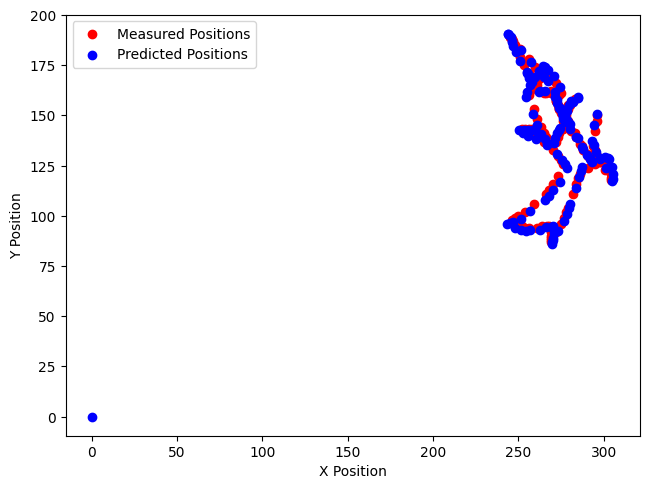

In [6]:

def main():
    VideoCap = cv2.VideoCapture('randomball.avi')

    # Variable used to control the speed of reading the video
    ControlSpeedVar = 100  # Lowest: 1 - Highest:100

    HiSpeed = 100

    # Create KalmanFilter object KF
    KF = KalmanFilter(0.1, 1, 1, 1, 0.1, 0.1)

    debugMode = 1

    measured_x = []# List to store measured positions
    measured_y=[]
    predicted_x=[]
    predicted_y = []  # List to store predicted positions

    while True:
        # Read frame
        ret, frame = VideoCap.read()

        # Detect object
        centers = detect(frame, debugMode)

        # If centroids are detected then track them
        if len(centers) > 0:
            # Draw the detected circle
            cv2.circle(frame, (int(centers[0][0]), int(centers[0][1])), 10, (0, 191, 255), 2)

            # Predict
            (x, y) = KF.predict()
            predicted_x.append(x)
            predicted_y.append(y)

            # Update
            (x1, y1) = KF.update(centers[0])
            measured_x.append(x1)
            measured_y.append(y1)

            # Draw a rectangle as the predicted object position
            cv2.rectangle(frame, (int(x) - 15, int(y) - 15), (int(x) + 15, int(y) + 15), (255, 0, 0), 2)

            # Draw a rectangle as the estimated object position
            cv2.rectangle(frame, (int(x1) - 15, int(y1) - 15), (int(x1) + 15, int(y1) + 15), (0, 0, 255), 2)

            cv2.putText(frame, "Estimated Position", (int(x1) + 15, int(y1) + 10), 0, 0.5, (0, 0, 255), 2)
            cv2.putText(frame, "Predicted Position", (int(x) + 15, int(y)), 0, 0.5, (255, 0, 0), 2)
            cv2.putText(frame, "Measured Position", (int(centers[0][0]) + 15, int(centers[0][1]) - 15), 0, 0.5,
                        (0, 191, 255), 2)

        cv2.imshow('image', frame)

        if cv2.waitKey(40) & 0xFF == ord('q'):
            VideoCap.release()
            cv2.destroyAllWindows()
            break

        cv2.waitKey(HiSpeed - ControlSpeedVar + 1)

    # Plot the measured and predicted positions
    plot_positions(measured_x, measured_y, predicted_x, predicted_y)

def plot_positions(measured_x, measured_y, predicted_x, predicted_y):
    # Plot measured positions in blue
    plt.figure()
    plt.scatter(measured_x, measured_y, label='Measured Positions', c='r')

    # Plot predicted positions in red
    plt.scatter(predicted_x, predicted_y, label='Predicted Positions', c='b')
    plt.tight_layout()

    # Set axis labels
    plt.xlabel('X Position')
    plt.ylabel('Y Position')

    # Set legend
    plt.legend()

    # Show the plot
    plt.show()


if __name__ == "__main__":
    # execute main
    main()


QObject::moveToThread: Current thread (0x3d029f90) is not the object's thread (0x3d785990).
Cannot move to target thread (0x3d029f90)

QObject::moveToThread: Current thread (0x3d029f90) is not the object's thread (0x3d785990).
Cannot move to target thread (0x3d029f90)

QObject::moveToThread: Current thread (0x3d029f90) is not the object's thread (0x3d785990).
Cannot move to target thread (0x3d029f90)

QObject::moveToThread: Current thread (0x3d029f90) is not the object's thread (0x3d785990).
Cannot move to target thread (0x3d029f90)

QObject::moveToThread: Current thread (0x3d029f90) is not the object's thread (0x3d785990).
Cannot move to target thread (0x3d029f90)

QObject::moveToThread: Current thread (0x3d029f90) is not the object's thread (0x3d785990).
Cannot move to target thread (0x3d029f90)

QObject::moveToThread: Current thread (0x3d029f90) is not the object's thread (0x3d785990).
Cannot move to target thread (0x3d029f90)

QObject::moveToThread: Current thread (0x3d029f90) is n

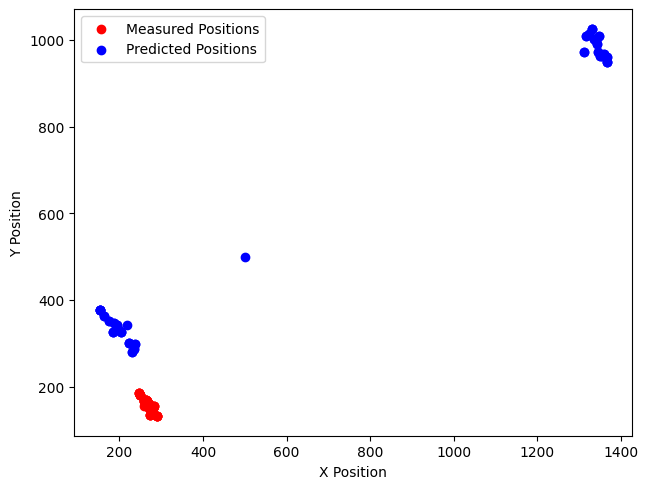

In [7]:
# ...

def main():
    # Create opencv video capture object
    VideoCap = cv2.VideoCapture('randomball.avi')

    # Variable used to control the speed of reading the video
    ControlSpeedVar = 100  # Lowest: 1 - Highest:100

    HiSpeed = 100

    # Create KalmanFilter object KF
    KF = KalmanFilter(1, 1000, 1000, 1000, 0.0001, 0.0001)

    debugMode = 1

    measured_x = []# List to store measured positions
    measured_y=[]
    predicted_x=[]
    predicted_y = []  # List to store predicted positions

    while True:
        # Read frame
        ret, frame = VideoCap.read()

        # Detect object
        centers = detect(frame, debugMode)

        # If centroids are detected then track them
        if len(centers) > 0:
            # Draw the detected circle
            cv2.circle(frame, (int(centers[0][0]), int(centers[0][1])), 10, (0, 191, 255), 2)

            # Predict
            (x, y) = KF.predict()
            predicted_x.append(x)
            predicted_y.append(y)

            # Update
            (x1, y1) = KF.update(centers[0])
            measured_x.append(x1)
            measured_y.append(y1)

            # Draw a rectangle as the predicted object position
            cv2.rectangle(frame, (int(x) - 15, int(y) - 15), (int(x) + 15, int(y) + 15), (255, 0, 0), 2)

            # Draw a rectangle as the estimated object position
            cv2.rectangle(frame, (int(x1) - 15, int(y1) - 15), (int(x1) + 15, int(y1) + 15), (0, 0, 255), 2)

            cv2.putText(frame, "Estimated Position", (int(x1) + 15, int(y1) + 10), 0, 0.5, (0, 0, 255), 2)
            cv2.putText(frame, "Predicted Position", (int(x) + 15, int(y)), 0, 0.5, (255, 0, 0), 2)
            cv2.putText(frame, "Measured Position", (int(centers[0][0]) + 15, int(centers[0][1]) - 15), 0, 0.5,
                        (0, 191, 255), 2)

        cv2.imshow('image', frame)

        if cv2.waitKey(40) & 0xFF == ord('q'):
            VideoCap.release()
            cv2.destroyAllWindows()
            break

        cv2.waitKey(HiSpeed - ControlSpeedVar + 1)

    # Plot the measured and predicted positions
    plot_positions(measured_x, measured_y, predicted_x, predicted_y)

def plot_positions(measured_x, measured_y, predicted_x, predicted_y):
    # Plot measured positions in blue
    plt.figure()
    plt.scatter(measured_x, measured_y, label='Measured Positions', c='r')

    # Plot predicted positions in red
    plt.scatter(predicted_x, predicted_y, label='Predicted Positions', c='b')
    plt.tight_layout()

    # Set axis labels
    plt.xlabel('X Position')
    plt.ylabel('Y Position')

    # Set legend
    plt.legend()

    # Show the plot
    plt.show()


if __name__ == "__main__":
    # execute main
    main()


QObject::moveToThread: Current thread (0x1c82380) is not the object's thread (0x2390f40).
Cannot move to target thread (0x1c82380)

QObject::moveToThread: Current thread (0x1c82380) is not the object's thread (0x2390f40).
Cannot move to target thread (0x1c82380)

QObject::moveToThread: Current thread (0x1c82380) is not the object's thread (0x2390f40).
Cannot move to target thread (0x1c82380)

QObject::moveToThread: Current thread (0x1c82380) is not the object's thread (0x2390f40).
Cannot move to target thread (0x1c82380)

QObject::moveToThread: Current thread (0x1c82380) is not the object's thread (0x2390f40).
Cannot move to target thread (0x1c82380)

QObject::moveToThread: Current thread (0x1c82380) is not the object's thread (0x2390f40).
Cannot move to target thread (0x1c82380)

QObject::moveToThread: Current thread (0x1c82380) is not the object's thread (0x2390f40).
Cannot move to target thread (0x1c82380)

QObject::moveToThread: Current thread (0x1c82380) is not the object's thread

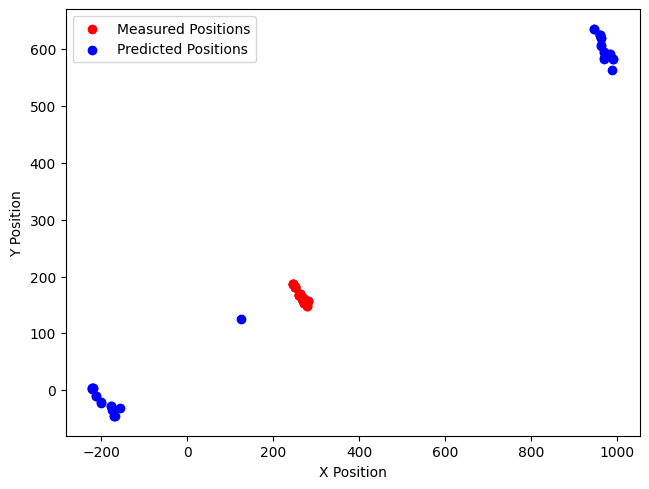

In [11]:
# ...

def main():
    # Create opencv video capture object
    VideoCap = cv2.VideoCapture('randomball.avi')

    # Variable used to control the speed of reading the video
    ControlSpeedVar = 100  # Lowest: 1 - Highest:100

    HiSpeed = 100

    # Create KalmanFilter object KF
    KF = KalmanFilter(0.5, 1000, 1000, 1000, 0.0001, 0.0001)

    debugMode = 1

    measured_x = []# List to store measured positions
    measured_y=[]
    predicted_x=[]
    predicted_y = []  # List to store predicted positionsq

    while True:
        # Read frame
        ret, frame = VideoCap.read()

        # Detect object
        centers = detect(frame, debugMode)

        # If centroids are detected then track them
        if len(centers) > 0:
            # Draw the detected circle
            cv2.circle(frame, (int(centers[0][0]), int(centers[0][1])), 10, (0, 191, 255), 2)

            # Predict
            (x, y) = KF.predict()
            predicted_x.append(x)
            predicted_y.append(y)

            # Update
            (x1, y1) = KF.update(centers[0])
            measured_x.append(x1)
            measured_y.append(y1)

            # Draw a rectangle as the predicted object position
            cv2.rectangle(frame, (int(x) - 15, int(y) - 15), (int(x) + 15, int(y) + 15), (255, 0, 0), 2)

            # Draw a rectangle as the estimated object position
            cv2.rectangle(frame, (int(x1) - 15, int(y1) - 15), (int(x1) + 15, int(y1) + 15), (0, 0, 255), 2)

            cv2.putText(frame, "Estimated Position", (int(x1) + 15, int(y1) + 10), 0, 0.5, (0, 0, 255), 2)
            cv2.putText(frame, "Predicted Position", (int(x) + 15, int(y)), 0, 0.5, (255, 0, 0), 2)
            cv2.putText(frame, "Measured Position", (int(centers[0][0]) + 15, int(centers[0][1]) - 15), 0, 0.5,
                        (0, 191, 255), 2)

        cv2.imshow('image', frame)

        if cv2.waitKey(100) & 0xFF == ord('q'):
            VideoCap.release()
            cv2.destroyAllWindows()
            break

        cv2.waitKey(HiSpeed - ControlSpeedVar + 1)

    # Plot the measured and predicted positions
    plot_positions(measured_x, measured_y, predicted_x, predicted_y)

def plot_positions(measured_x, measured_y, predicted_x, predicted_y):
    # Plot measured positions in blue
    plt.figure()
    plt.scatter(measured_x, measured_y, label='Measured Positions', c='r')

    # Plot predicted positions in red
    plt.scatter(predicted_x, predicted_y, label='Predicted Positions', c='b')
    plt.tight_layout()

    # Set axis labels
    plt.xlabel('X Position')
    plt.ylabel('Y Position')

    # Set legend
    plt.legend()

    # Show the plot
    plt.show()


if __name__ == "__main__":
    # execute main
    main()
